In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from fastaudio.all import *
from fastai.vision.all import *

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
path = Path('rfcx-species-audio-detection/')
path.ls()

(#9) [Path('rfcx-species-audio-detection/hello.png'),Path('rfcx-species-audio-detection/sample_submission.csv'),Path('rfcx-species-audio-detection/test'),Path('rfcx-species-audio-detection/test_spectrogram'),Path('rfcx-species-audio-detection/tfrecords'),Path('rfcx-species-audio-detection/train'),Path('rfcx-species-audio-detection/train_fp.csv'),Path('rfcx-species-audio-detection/train_spectrogram'),Path('rfcx-species-audio-detection/train_tp.csv')]

In [4]:
train_path = path/'train'
test_path = path/'test'

In [5]:
df_train_tp = pd.read_csv(path / 'train_tp.csv')
df_train_tp["recording_id"] = df_train_tp["recording_id"].map(lambda x: "train/"+x)
df_train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,train/003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,train/006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,train/007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,train/0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,train/009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [6]:
df_train_tp = df_train_tp.drop(['t_min', 't_max', 'f_min', 'f_max', 'songtype_id'], axis=1)
df_train_tp['species_id'] = df_train_tp['species_id'].astype(str)
df_train_tp.head()

,recording_id,species_id
0,train/003bec244,14
1,train/006ab765f,23
2,train/007f87ba2,12
3,train/0099c367b,17
4,train/009b760e6,10


In [7]:
df_train_tp['species_id'] = df_train_tp.groupby('recording_id')['species_id'].transform(",".join)
df_train_tp = df_train_tp.reset_index()

In [8]:

audio_to_spec = AudioToSpec.from_cfg(AudioConfig.BasicMelSpectrogram(n_fft=512, n_mels=32))

# Adding some data augmentation
data_augmentation = [AddNoise(color=NoiseColor.White, noise_level=0.1), SignalShifter(max_pct=0.3)]

blocks = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                  get_x = ColReader('recording_id', pref=str(path.resolve())+"/", suff='.flac'),
                  get_y = ColReader('species_id', label_delim=','),
                  item_tfms = data_augmentation,
                  batch_tfms = audio_to_spec,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42)
                  )

In [9]:
dls = blocks.dataloaders(df_train_tp, bs=16, num_workers=0)

C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\arnav\Anaconda3\envs\fastai2\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


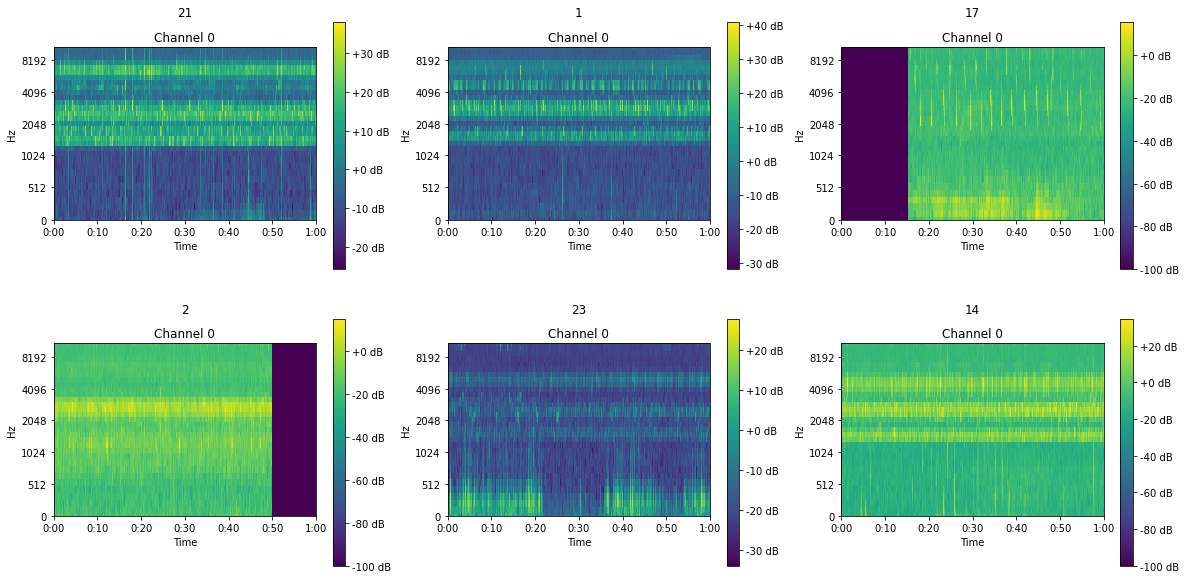

In [10]:
dls.show_batch(ncols=3, nrows=2, figsize=(20, 10))

In [11]:
learner = cnn_learner(dls, resnet18, config={"n_in":1})

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.04786301031708717)

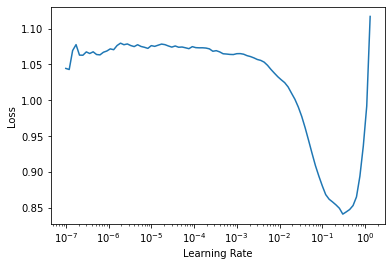

In [12]:
learner.lr_find()

In [13]:
learner.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,time
0,0.453942,0.301088,08:00
1,0.290764,0.192109,07:52
2,0.205168,0.162400,07:42
3,0.164410,0.138473,07:46
4,0.140646,0.129342,07:30


In [14]:
learner.save('s1-18-5')

Path('models/s1-18-5.pth')

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=6.309573450380412e-07)

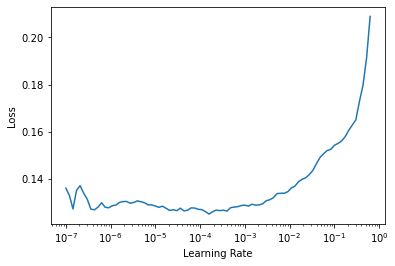

In [15]:
learner.load('s1-18-5')
learner.unfreeze()
learner.lr_find()

In [16]:
learner.fine_tune(2, base_lr=1e-5) # prev 4 epochs

epoch,train_loss,valid_loss,time
0,0.127396,0.130757,06:07


epoch,train_loss,valid_loss,time
0,0.127640,0.130358,07:09
1,0.125143,0.130419,07:15


In [17]:
submission_df = pd.read_csv(path / 'sample_submission.csv')
submission_df["recording_id"] = submission_df["recording_id"].map(lambda x: "test/"+x)
submission_df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,test/000316da7,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,test/003bc2cb2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,test/0061c037e,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,test/010eb14d3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,test/011318064,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,test/ff68f3ac3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1988,test/ff973e852,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1989,test/ffa5cf6d6,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1990,test/ffa88cbb8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [18]:
# Easily create test dataloader and get the predictions
test_dl = dls.test_dl(submission_df)
preds = learner.get_preds(dl = test_dl)

In [19]:
# Copy the predictions into the submission dataframe
submission_df.iloc[:, 1:] = preds[0]

In [20]:
tmp = pd.read_csv(path / 'sample_submission.csv')
submission_df["recording_id"] = tmp["recording_id"]
submission_df.to_csv('submission.csv', index=False)

In [22]:
?AudioConfig.BasicMelSpectrogram

In [26]:
?torchaudio.transforms.MelSpectrogram

In [25]:
?torchaudio.transforms.AmplitudeToDB